In [8]:
import geopandas as gpd
from sqlalchemy import create_engine

# --- สร้าง SQLAlchemy engine ---
PG_USER = "postgres"
PG_PASS = "1234"
PG_HOST = "localhost"
PG_PORT = "6508"
PG_DB   = "Project499"

engine = create_engine(
    f"postgresql+psycopg2://{PG_USER}:{PG_PASS}@{PG_HOST}:{PG_PORT}/{PG_DB}"
)

# --- เลือกฟิลด์/ตัวกรองตามต้องการ ---
sql = """
SELECT
    id,
    label, 
    geom
FROM public.detections_matched_all
WHERE label IS NOT NULL
"""

gdf = gpd.read_postgis(sql, engine, geom_col="geom")
print(gdf.head(), gdf.crs)
print(f"n = {len(gdf)}")


   id label                       geom
0   1   ENV  POINT (98.98303 18.76662)
1   2   EDC  POINT (98.98312 18.76664)
2   4   EDC  POINT (98.98233 18.76678)
3   7   ENV   POINT (98.98308 18.7669)
4   8   EDC  POINT (98.98298 18.76689) EPSG:4326
n = 34611


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------
# 1) Core functions
# ----------------------------
def compute_gini(values: np.ndarray) -> float:
    """
    คำนวณดัชนี Gini จากอาร์เรย์ของค่าที่ไม่เป็นลบ
    สูตรใช้พื้นที่ใต้เส้น Lorenz (trapezoidal rule)
    """
    x = np.asarray(values, dtype=float)
    if np.any(x < 0):
        raise ValueError("All values must be non-negative.")
    if x.sum() == 0:
        return 0.0  # กรณีทั้งหมดเป็นศูนย์ถือว่าเท่าเทียม

    # เรียงจากน้อยไปมาก (นิยาม Lorenz ต้องการลำดับจากน้อย->มาก)
    x_sorted = np.sort(x)
    cumx = np.cumsum(x_sorted)
    total = cumx[-1]

    # จุดของ Lorenz curve: (X, Y) รวมจุดกำเนิด (0,0)
    n = len(x_sorted)
    X = np.linspace(0, 1, n + 1)              # สัดส่วนสะสมของหน่วย (พื้นที่/ย่าน/คน)
    Y = np.concatenate(([0.0], cumx / total)) # สัดส่วนสะสมของทรัพยากร/บริการ

    # พื้นที่ใต้เส้น Lorenz ด้วย trapezoidal rule
    area = np.trapz(Y, X)
    gini = 1.0 - 2.0 * area
    return float(gini)


def lorenz_points(values: np.ndarray):
    """
    คืนค่า (X, Y) สำหรับวาดเส้น Lorenz curve
    X = สัดส่วนสะสมของหน่วย, Y = สัดส่วนสะสมของค่ารวม
    """
    x = np.asarray(values, dtype=float)
    x_sorted = np.sort(x)
    cumx = np.cumsum(x_sorted)
    total = cumx[-1] if cumx[-1] != 0 else 1.0
    n = len(x_sorted)
    X = np.linspace(0, 1, n + 1)
    Y = np.concatenate(([0.0], cumx / total))
    return X, Y


def plot_lorenz(values: np.ndarray, title: str = "Lorenz Curve"):
    X, Y = lorenz_points(values)
    gini = compute_gini(values)

    plt.figure(figsize=(6, 6))
    plt.plot(X, Y, marker="o", linewidth=2, label="Lorenz curve")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Line of equality")
    plt.title(f"{title}\nGini = {gini:.4f}")
    plt.xlabel("Cumulative share of units (areas)")
    plt.ylabel("Cumulative share of services")
    plt.legend()
    plt.grid(True, linestyle=":", linewidth=0.7)
    plt.show()

    return gini


[{'label': 'ENV', 'count': 11146}, {'label': 'TEC', 'count': 10209}, {'label': 'RES', 'count': 5641}, {'label': 'EDC', 'count': 5010}, {'label': 'HLT', 'count': 1595}, {'label': 'TRN', 'count': 629}, {'label': 'PSG', 'count': 381}]
Gini (7 areas) = 0.4582


/var/folders/qm/p5vffjb56gvb80sz8bwjxy780000gn/T/ipykernel_45067/3572983363.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(Y, X)


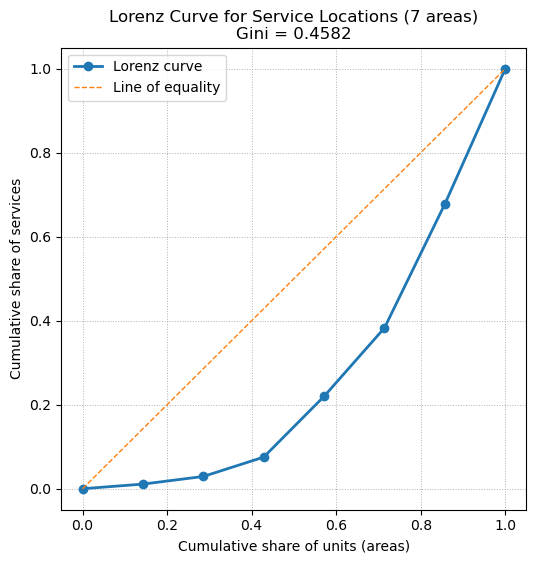

0.45816152585676717

In [ ]:
# get data from db
data = (
    gdf.groupby("label")
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
    .to_dict(orient="records")
)

print(data)

df = pd.DataFrame(data)

# คำนวณ Gini
gini_value = compute_gini(df["count"].to_numpy())
print(f"Gini (7 areas) = {gini_value:.4f}")

# วาดกราฟ Lorenz
plot_lorenz(df["count"].to_numpy(), title="Lorenz Curve for Service Locations (7 areas)")


In [20]:
import numpy as np
from libpysal.weights import KNN, DistanceBand

# --- Project ไปยัง CRS แบบเมตร (เลือก EPSG ที่เหมาะสมกับพื้นที่) ---
# ตัวอย่าง: Thailand ส่วนใหญ่ใช้ UTM zone 47N/48N แล้วแต่ลองจิจูด
if gdf.crs is None or gdf.crs.to_epsg() != 32647:
    gdf = gdf.to_crs(epsg=32647)

# --- เตรียม coords สำหรับสร้าง weights ---
# ตรวจสอบและทำความสะอาดข้อมูลก่อน
print(f"Original data shape: {gdf.shape}")

# กรองข้อมูลที่มี geometry ที่ถูกต้อง
gdf_clean = gdf[gdf.geometry.notna() & gdf.geometry.is_valid].copy()
print(f"After removing invalid geometries: {gdf_clean.shape}")

coords = np.vstack([gdf_clean.geometry.x, gdf_clean.geometry.y]).T

# ตรวจสอบ NaN หรือ inf values
finite_mask = np.isfinite(coords).all(axis=1)
coords_clean = coords[finite_mask]
gdf_final = gdf_clean[finite_mask].copy()

print(f"After removing NaN/inf coordinates: {coords_clean.shape}")
print(f"Final GeoDataFrame shape: {gdf_final.shape}")

# วิธีที่ 1: KNN (เช่น k = 8)
k = 8
w_knn = KNN.from_array(coords_clean, k=k)
w_knn.transform = "R"  # row-standardized

# หรือ วิธีที่ 2: Distance Band (เช่น 10 กม. = 10,000 m; include_self=False)
# radius_m = 10000
# w_dist = DistanceBand.from_array(coords, threshold=radius_m, binary=True, silence_warnings=True)
# w_dist.transform = "R"


Original data shape: (34611, 3)
After removing invalid geometries: (34609, 3)
After removing NaN/inf coordinates: (34609, 2)
Final GeoDataFrame shape: (34609, 3)


In [27]:
from esda import Moran, Moran_Local
import numpy as np

# --- ตัวแปรที่จะวิเคราะห์ ---
# สร้างตัวแปรเชิงตัวเลขจาก label โดยนับจำนวนในแต่ละพื้นที่
# หรือใช้ label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(gdf_final["label"])
print(f"Label encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

# --- Global Moran’s I (ใช้ w_knn) ---
mi = Moran(y, w_knn, permutations=999) 
print(f"Global Moran's I = {mi.I:.4f}")
print(f"p-value (permutation) = {mi.p_sim:.4f}")
print(f"z-score (normal approx.) = {mi.z_norm:.4f}")

# --- Local Moran’s I (LISA) ---
m_local = Moran_Local(y, w_knn, permutations=999)

# นำผล LISA กลับเข้า GeoDataFrame
gdf_final["Ii"]      = m_local.Is                 # local Moran's I ของแต่ละจุด
gdf_final["p_sim"]   = m_local.p_sim              # p-value จาก permutation
gdf_final["z_sim"]   = m_local.z_sim              # z-score จาก permutation
gdf_final["q"]       = m_local.q                  # quadrant (1=HH, 2=LH, 3=LL, 4=HL) บน Moran scatterplot
gdf_final["sig_95"]  = (gdf_final["p_sim"] <= 0.05)     # สถานะนัยสำคัญที่ 95%

# ตีความคลัสเตอร์ตาม quadrant
# 1 = High-High (HH), 2 = Low-High (LH), 3 = Low-Low (LL), 4 = High-Low (HL)
def cluster_label(row):
    if not row["sig_95"]:
        return "Not significant"
    return {1: "High-High", 2: "Low-High", 3: "Low-Low", 4: "High-Low"}.get(row["q"], "Not significant")

gdf_final["cluster"] = gdf_final.apply(cluster_label, axis=1)

# Update the original gdf with results for compatibility with later cells
gdf = gdf_final.copy()

print(gdf_final[["id", "label", "Ii", "p_sim", "cluster"]].head())


Label encoding: {'EDC': 0, 'ENV': 1, 'HLT': 2, 'PSG': 3, 'RES': 4, 'TEC': 5, 'TRN': 6}
Global Moran's I = 0.2657
p-value (permutation) = 0.0010
z-score (normal approx.) = 103.8046
   id label        Ii  p_sim          cluster
0   1   ENV  0.960854  0.001          Low-Low
1   2   EDC  1.448778  0.001          Low-Low
2   4   EDC  0.204475  0.373  Not significant
3   7   ENV  0.700670  0.009          Low-Low
4   8   EDC  1.034010  0.013          Low-Low


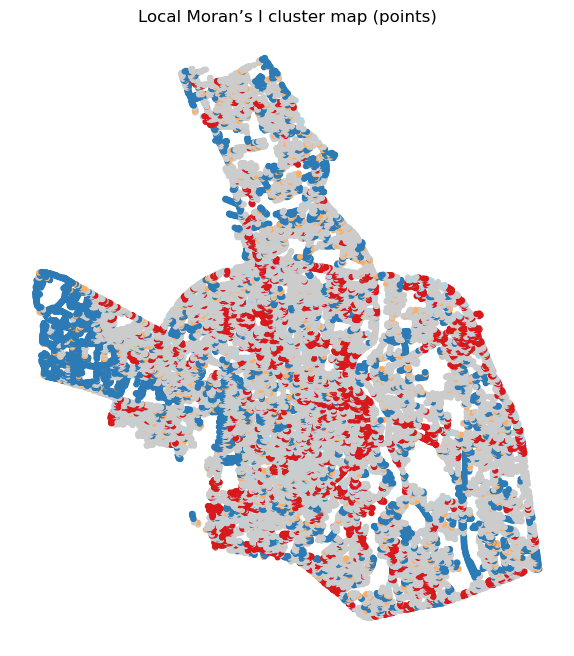

In [28]:
import matplotlib.pyplot as plt

# กำหนดสีแบบง่าย
color_map = {
    "High-High": "#d7191c",
    "Low-Low":   "#2c7bb6",
    "High-Low":  "#fdae61",
    "Low-High":  "#abd9e9",
    "Not significant": "#cccccc"
}
gdf["color"] = gdf["cluster"].map(color_map)

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(color=gdf["color"], markersize=12, ax=ax)
ax.set_title("Local Moran’s I cluster map (points)")
ax.axis("off")
plt.show()
